## 1. Data of Interests

### In the proposal, most projects only focus on a subset of data. Please state the subset of data to explore again here.

The goal of our project is to explore the relationship between food cuisines (Italian, French, Mexican, Chinese, etc) and consumer ratings relative to the time of day. In order to do this, we will use yelp's dataset. Our subset of will contain all the restaurants on yelp with the tag 'restaurant' as a category in 'business.json' and the corresponding reviews associated with them in 'tip.json'

## 2. Data Preprocessing

### Describe what preprocessing is done. This includes details of cleaning and reorganization.

For preprocessing, we first extracted all the businesses from business.json to filter for restaurants. Initially, the tags were all embedded in a string, so we were able to clean the dataset by parsing each category list and converted them into a list of category by delminating the string. We did some prelimary analysis to seach for the most common categories in the dataset and concluded the most common but still relevant category were 'restaurants'. The tag for 'food' contained entries such as grocery stores, and thus was ommited. From there we collected all the entries with those tags and gathered their 'business_id', and retrieved all the coresponding reviews from 'tip.json'. We also noticed from EDA testing that the times for each tip were in GMT, so we converted the GMT times into local times.

In [1]:
# load dataset
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from timezonefinder import TimezoneFinder

In [2]:
filepath = '../../yelp_dataset'

business = []
for l in open(filepath+"/business.json", encoding="utf8").readlines():
    business.append(json.loads(l))
df_business = pd.DataFrame.from_records(business)

tips = []
for l in open(filepath+"/tip.json", encoding="utf8").readlines():
    tips.append(json.loads(l))
df_tip = pd.DataFrame.from_records(tips) 

In [3]:
filepath = '../../yelp_dataset'

reviews = []
for l in open(filepath+"/review.json", encoding="utf8").readlines():
    reviews.append(json.loads(l))
df_review = pd.DataFrame.from_records(reviews) 

KeyboardInterrupt: 

In [4]:
# Find business categories
categories = {}
for _, row in df_business.iterrows():
    if row.categories:
        row_categories = row.categories.split(', ')
        for category in row_categories:
            if category not in categories:
                categories[category] = 1
            else:
                categories[category] += 1
categories = {k: v for k, v in sorted(categories.items(), key=lambda item: item[1])}


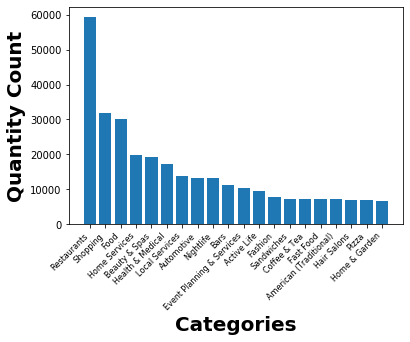

In [6]:
# Top 10 categories
top_20 = dict(list(categories.items())[-20:]) 

x = list(top_20.keys())
x.reverse()
x = np.array(x)
y = list(top_20.values())
y.reverse()
y = np.array(y)


fig, ax = plt.subplots()
plt.bar(x, y)
plt.xticks(x, x, color='black', rotation=45, fontsize='8', horizontalalignment='right')
plt.xlabel("Categories", fontweight='bold', fontsize='20')
plt.ylabel("Quantity Count", fontweight='bold', fontsize='20')

plt.show()

In [7]:
# OLD VERSION THAT INCLUDED FOOD

# Filter businesses that are only in the 'Food' or 'Restaurant' category
def check_for_rest_or_food(row):
    category = row['categories']
    if category:
        tokens = category.split(', ')
        return 'Food' in tokens or 'Restaurants' in tokens
    return False

# df_business['is_restaurant_or_food'] = df_business.apply(check_for_rest_or_food, axis=1)

# food_businesses = df_business[df_business['is_restaurant_or_food'] == True]

In [8]:
# Filter businesses that are only in the 'Restaurant' category
def check_for_rest(row):
    category = row['categories']
    if category:
        tokens = category.split(', ')
        return 'Restaurants' in tokens
    return False

df_business['is_restaurant'] = df_business.apply(check_for_rest, axis=1)

food_businesses = df_business[df_business['is_restaurant'] == True]

# Get the unique IDs for all the businesses that are resturaunts
restaurant_ids  = set(food_businesses['business_id'].unique())

print('Total Unique ID count:',len(restaurant_ids))

Total Unique ID count: 59371


In [9]:
# Get count of total number of reviews per business
df_rest_tip = df_tip[df_tip['business_id'].isin(restaurant_ids)]

print('Total Number of Tips With Resturaunt tag:', len(df_rest_tip))

Total Number of Tips With Resturaunt tag: 810342


In [ ]:
# Convert from GMT time zone to local time zone
# Add local time to dataframe 
tf = TimezoneFinder()
time_zone_from_utc = {
'America/Phoenix': -7, 
'America/Los_Angeles': -7, 
'America/Toronto': -5 , 
'America/New_York' : -5, 
'America/Chicago': -6 , 
'America/Edmonton':  -7
}
counter = 0

def extract_hour(date_time):
    date_time_list = date_time.split()
    time_list = date_time_list[-1].split(':')
    return int(time_list[-3])

def get_local_hour(row):
    business_id = row['business_id']
    business = food_businesses[food_businesses['business_id'] == business_id]
    latitude = list(business['latitude'])[0]
    longitude = list(business['longitude'])[0]
    time_zone = tf.timezone_at(lng=longitude, lat=latitude)
    normalized_hour = extract_hour(row['date'])
    local_hour = normalized_hour + time_zone_from_utc[time_zone]
    if local_hour < 0:
        local_hour = 24 + local_hour
    global counter
    counter += 1
    if (counter % 500) == 0: 
        print(counter)
    return local_hour

df_rest_tip['local_hour'] = df_rest_tip.apply(get_local_hour, axis=1)

In [ ]:
df_rest_tip.to_json('./restaurant_tips.json', orient='records')

In [ ]:
print(df_rest_tip)

In [ ]:
df_review['local_hour'] = df_review.apply(get_local_hour, axis=1)

## 3. EDA

### Describe in detail what EDA and Statistical Testing are performed. You should perform at least three meaningful plots/testings. Please also summarize the insights from EDA.

#### Quick Aside About Project Scope

Initially, our goal of our project was to identify "Which cuisines are most positively received in certain region (West, Midwest, Northeast, and South) of the continental United States?” The subset of data that we initially exploredwas  the yelp dataset in business.json for entries in the continental United States only. (All US states except Alaska and Hawaii, not including Washington D.C.). The states will be divided up by region National Geographic's guideline for United States regions (https://www.nationalgeographic.org/maps/united-states-regions/). 

After examining the distributions of reviews for each region, we noticed that the data set was heavily skewed; some states such as Utah only had 1 review while others such as Arizona had 56000+. Because of this we had to modify our goal and scope of our original project to it's current goal.

Fortunately, due to EDA we were able to identify this issue and pivot the scope of our project right away

In [ ]:
# load dataset
import json
import pandas as pd

filepath = '../../yelp_dataset'

business = []
for l in open(filepath+"/business.json", encoding="utf8").readlines():
    business.append(json.loads(l))
df_business = pd.DataFrame.from_records(business)

# cleaning data for inconsistent state names

west = ['WA', 'OR', 'ID', 'MT', 'WY', 'CA', 'NV', 'UT', 'CO']
southwest = ['AZ', 'NM', 'OK', 'TX']
midwest = ['ND', 'SD', 'KS', 'MO', 'NE', 'IA', 'MN', 'WI', 'IL', 'MI', 'IN', 'OH']
northeast = ['ME', 'NH', 'VT', 'NY', 'RI', 'CT', 'MA', 'PA', 'NJ']
southeast = ['WV', 'MD', 'DE', 'VA', 'KY', 'NC', 'TN', 'SC', 'GA', 'AL', 'MS', 'AR', 'LA', 'FL']
states = west + southwest + midwest + northeast + southeast

states_mappings = {
    'WASHINGTON': 'WA', 
    'OREGON': 'OR', 
    'IDAHO': 'ID',
    'MONTANA': 'MT', 
    'WYOMING': 'WY', 
    'CALIFORNIA': 'CA', 
    'NEVADA': 'NV', 'UTAH': 'UT', 
    'COLORADO': 'CO',
    'ARIZONA': 'AZ', 
    'NEW MEXICO': 'NM', 
    'OKLAHOMA': 'OK', 
    'TEXAS': 'TX',
    'NORTH DAKOTA' : 'ND',
    'SOUTH DAKOTA' : 'SD',
    'KANSAS' : 'KS',
    'MONTANA' : 'MO',
    'NEBRASKA' : 'NE',
    'IOWA' : 'IA',
    'MINNESOTA' : 'MN',
    'WISCONSIN' : 'WI',
    'ILLINOIS' : 'IL',
    'MICHIGAN' : 'MI',
    'INDIANA' : 'IN',
    'OHIO' : 'OH',
    'MAINE' : 'ME',
    'NEW HAMPSHIRE' : 'NH',
    'VERMONT' : 'VT',
    'NEW YORK' : 'NY',
    'RHODE ISLAND' : 'RI',
    'CONNECTICUT' : 'CT',
    'MASSACHUSETTS' : 'MA',
    'PENNSYLVANIA' : 'PA',
    'NEW JERSEY' : 'NJ',
    'WEST VIRGINA' : 'WV',
    'MARYLAND' : 'MD',
    'DELAWARE' : 'DE',
    'VIRGINIA' : 'VA',
    'KENTUCKY' : 'KY',
    'NORTH CAROLINA' : 'NC',
    'TENNESSEE' : 'TN',
    'SOUTH CAROLINA' : 'SC',
    'GEORGIA' : 'GA',
    'ALABAMA' : 'AL',
    'MISSOURI' : 'MS', 
    'ARKANSAS' : 'AR', 
    'LOUISIANA' : 'LA', 
    'FLORIDA' : 'FL'
}

def convert_to_upper_abr(state):
    state = state.upper()
    if state in states_mappings:
        return states_mappings[state]
    return state

# convert all state entries to upper case and fix inconsistencies with states fully spelled our vs abb
for _, row in df_business.iterrows():
    row.state = convert_to_upper_abr(row.state)
    
# filter dataset by region
df_us_states = df_business.loc[df_business['state'].isin(states)]
print(df_us_states['state'].value_counts())
west_businesses = df_business.loc[df_business['state'].isin(west)]
south_businesses = df_business.loc[df_business['state'].isin(southwest)]
midwest_businesses = df_business.loc[df_business['state'].isin(midwest)]
northeast_businesses = df_business.loc[df_business['state'].isin(northeast)]
southeast_businesses = df_business.loc[df_business['state'].isin(southeast)]

# print('Total West:',len(west_businesses))
# print('Total South:',len(south_businesses))
# print('Total Midwest:',len(midwest_businesses))
# print('Total Northeast:',len(northeast_businesses))
# print('Total Southeast:',len(southeast_businesses))
import matplotlib.pyplot as plt 

plt.boxplot([west_businesses.stars, south_businesses.stars, midwest_businesses.stars, northeast_businesses.stars, southeast_businesses.stars])
plt.xticks([1, 2, 3, 4, 5], ['West', 'South', 'Midwest', 'Northeast', 'Southeast'])
plt.show()

From examining the boxplots and state review counts, even though the distributions of businesses are relatively similar, some of the datasets are too small to conduct meaningful analysis

#### Current Project's EDA

The second EDA test we performed was plotting a histogram showing the distribution of review count against timestamps for reviews in tip based on businesses with the restaurant tag 

In [ ]:
# Get tips and time of day reviewed]
def extract_time(row):
    date_time_list = row.split()
    time_list = date_time_list[-1].split(':')
    return int(time_list[-3])

tip_times = df_rest_tip.date.apply(extract_time)

In [ ]:
tip_times.plot.hist(bins=24)

In [ ]:
filepath = '../submission3/'
df_restaurant_tips = pd.read_json(filepath+"restaurant_tips.json", encoding="utf8")

In [ ]:
df_restaurant_tips['local_hour'].plot.hist(bins=24)
plt.xlabel("Hour")
plt.xticks(np.arange(0, 24, step=2))

Before plotting the histogram, we expected peaks of tips to be centered around meal times (9am, 12pm, and 6pm). However, the resulting histogram was unexpected as it shows most tips around 6pm-3am. One possible reason for this discrepancy is all tips were normalized to be in the GMT time zone. To account for this, we further preprocessed the data to convert all UTC times to the local times.

The third EDA test we performed was to check the how the tip counts per unique business_id are distrubuted via a PDF

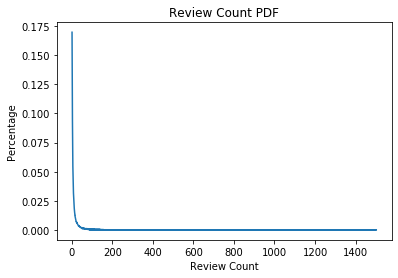

In [10]:
import matplotlib.pyplot as plt

tips_count = df_rest_tip['business_id'].value_counts()
tips_count = tips_count.value_counts()

x = np.array(tips_count.index.values)
y = np.array(tips_count.tolist())
total = np.sum(y)
y = np.true_divide(y, total)

plt.plot(x, y)
plt.xlabel('Review Count')
plt.ylabel('Percentage')
plt.title('Review Count PDF')
plt.show()

After visual inspection, the distribution seems to follow the Power Law. Now we will prove if this the distribution follows the Power Law or not

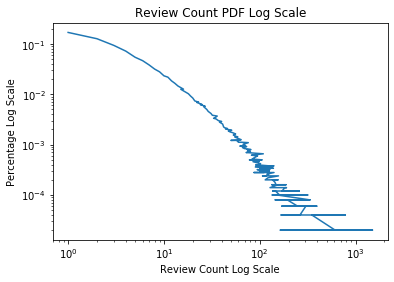

In [11]:
plt.loglog(x,y)
plt.xlabel('Review Count Log Scale')
plt.ylabel('Percentage Log Scale')
plt.title('Review Count PDF Log Scale')
plt.show()

The relationship still seems relatively linear, but there is noise towards the end. We will now clean up the graph via binning

Text(0.5, 1.0, 'Review Count PDF Bins=190')

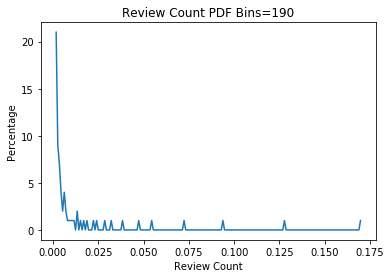

In [12]:
counts, bins = np.histogram(y, bins = 190)

x_min_index = 2


bins=bins[x_min_index:]
counts = counts[x_min_index-1:]

plt.plot(bins,counts)
plt.xlabel('Review Count')
plt.ylabel('Percentage')
plt.title('Review Count PDF Bins=190')

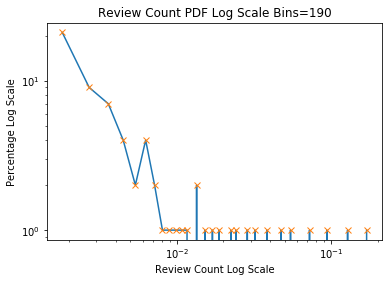

In [13]:
plt.plot(bins, counts)
plt.loglog(bins, counts, 'x')
plt.xlabel('Review Count Log Scale')
plt.ylabel('Percentage Log Scale')
plt.title('Review Count PDF Log Scale Bins=190')
plt.show()

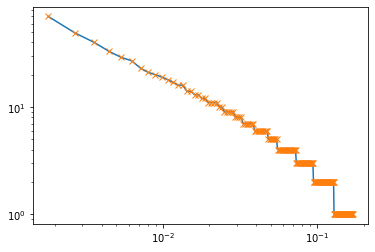

In [14]:
# Examining CCDF
counts2 = counts[::-1]
counts2 = np.cumsum(counts2)
counts2 = counts2[::-1]

plt.figure()
plt.plot(bins, counts2)
plt.loglog(bins, counts2, 'x')

In [15]:
from scipy.stats import pearsonr
import powerlaw

# Examining Statistics

bins_log = np.log(bins)
counts2_log = np.log(counts2)

corr, _ = pearsonr(bins_log, counts2_log)
print('Pearsons correlation: %.3f' % corr)

data = counts2
results = powerlaw.Fit(data)
print("alpha =", results.power_law.alpha)

Pearsons correlation: -0.971
alpha = 2.5939319723571845


Calculating best minimal value for power law fit
/Users/leannahue/Library/Python/3.7/lib/python/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Given a Pearsons Correlation Coefficient of -.971 and an alpha of 2.5939319723571845, we can conclude that the relationsip is Very Strongly Negatively Correlated and that it follows a Power Law Curve. Now that we know that the distribution follows the Power Law, we can then use this knowledge in further analysis to help normalize our dataset. This can apply in cases where a restaurant with fewer total reviews can be more negatively biased by one negative review versus one negative review would not affect a restaurant with more total reviews.